# Train on combined languages

In [1]:
import json
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    TrainerCallback
)

In [2]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.cuda.empty_cache()

In [3]:
file_path_welsh = "data/massive_amr_welsh.jsonl"
file_path_eng = "data/massive_amr.jsonl"
file_path_irish = "data/massive_amr_irish.jsonl"

In [4]:
# Combine the datasets into one file
all_data = []
for file_path in [file_path_welsh, file_path_eng, file_path_irish]:
    with open(file_path, "r", encoding="utf-8") as f:
        all_data.extend(f.readlines())

# Shuffle the data
random.shuffle(all_data)

# Save to a new file
file_path_all = "data/massive_amr_all.jsonl"
with open(file_path_all, "w", encoding="utf-8") as f:
    f.writelines(all_data)

In [5]:
# ----------------------------
# 2. Load and Preprocess the Dataset
# ----------------------------
def load_amr_data(file_path):
    """Loads JSONL AMR dataset and removes incomplete entries."""
    with open(file_path, "r", encoding="utf-8") as file:
        data = [json.loads(line) for line in file]
    # Remove entries missing either the sentence or AMR
    return [entry for entry in data if entry.get("raw_amr") and entry.get("utt")]

In [6]:
# Load dataset
data = load_amr_data(file_path_all)
random.shuffle(data)

In [7]:
# Extract sentences and AMR graphs
sentences = [entry["utt"] for entry in data]
amrs = [entry["raw_amr"] for entry in data]

# Split into train, validation, and test sets (80% train, 10% validation, 10% test)
train_sents, test_sents, train_amrs, test_amrs = train_test_split(sentences, amrs, test_size=0.1, random_state=42)
train_sents, val_sents, train_amrs, val_amrs = train_test_split(train_sents, train_amrs, test_size=0.1, random_state=42)

In [8]:
# Convert to Hugging Face Dataset format
def create_dataset(sentences, amrs):
    return Dataset.from_dict({"sentence": sentences, "amr": amrs})

datasets = DatasetDict({
    "train": create_dataset(train_sents, train_amrs),
    "validation": create_dataset(val_sents, val_amrs),
    "test": create_dataset(test_sents, test_amrs),
})

In [9]:
# ==============================
# 3. Load Multilingual T5 Model (STOG & GTOS)
# ==============================
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
def preprocess_function(examples):
    # For T5 it's common to add a task prefix. Here we add "parse: " before the sentence.
    inputs = ["parse: " + ex for ex in examples["sentence"]]
    targets = examples["amr"]

    # Tokenize inputs (source) and targets
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=512, truncation=True, padding="max_length")

    # Replace padding token id's in labels with -100 so they are ignored by the loss function
    labels["input_ids"] = [
        [l if l != tokenizer.pad_token_id else -100 for l in label]
        for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [11]:
# Apply tokenization
tokenized_datasets = datasets.map(preprocess_function, batched=True, remove_columns=["sentence", "amr"])

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Map:   0%|          | 0/4094 [00:00<?, ? examples/s]

Map:   0%|          | 0/455 [00:00<?, ? examples/s]

Map:   0%|          | 0/506 [00:00<?, ? examples/s]

In [12]:
# ==============================
# 5. Define Optimized Training Arguments
# ==============================
training_args = TrainingArguments(
    output_dir="./amr_t5_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    logging_steps=50,
    logging_dir="./logs",
    report_to="none",
)

c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# ----------------------------
# 6. Custom Callback for Logging and Visualization
# ----------------------------
class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if "loss" in logs:
                self.losses.append((state.global_step, logs["loss"]))
            if "eval_loss" in logs:
                self.eval_losses.append((state.global_step, logs["eval_loss"]))

    def plot_loss(self):
        steps, losses = zip(*self.losses)
        eval_steps, eval_losses = zip(*self.eval_losses)

        plt.figure(figsize=(10, 5))
        plt.plot(steps, losses, label="Training Loss", marker="o")
        plt.plot(eval_steps, eval_losses, label="Validation Loss", marker="x")
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Training & Validation Loss Curve")
        plt.legend()
        plt.show()

In [14]:
loss_callback = LossCallback()

In [15]:
# ----------------------------
# 7. Initialize Trainer and Train the Model
# ----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_callback],
)

C:\Users\stoic\AppData\Local\Temp\ipykernel_21636\3038309954.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
print("Starting T5 Training for AMR Parsing on All Languages...")
trainer.train()

Starting T5 Training for AMR Parsing on All Languages...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.639700,0.519809
2,0.482800,0.410130
3,0.433600,0.360012
4,0.365200,0.328650
5,0.320800,0.307708
6,0.337800,0.291863
7,0.286700,0.279627
8,0.289700,0.271582
9,0.279500,0.266852
10,0.267800,0.266185


TrainOutput(global_step=5120, training_loss=0.4163268807344139, metrics={'train_runtime': 1517.1688, 'train_samples_per_second': 26.984, 'train_steps_per_second': 3.375, 'total_flos': 2770446676131840.0, 'train_loss': 0.4163268807344139, 'epoch': 10.0})

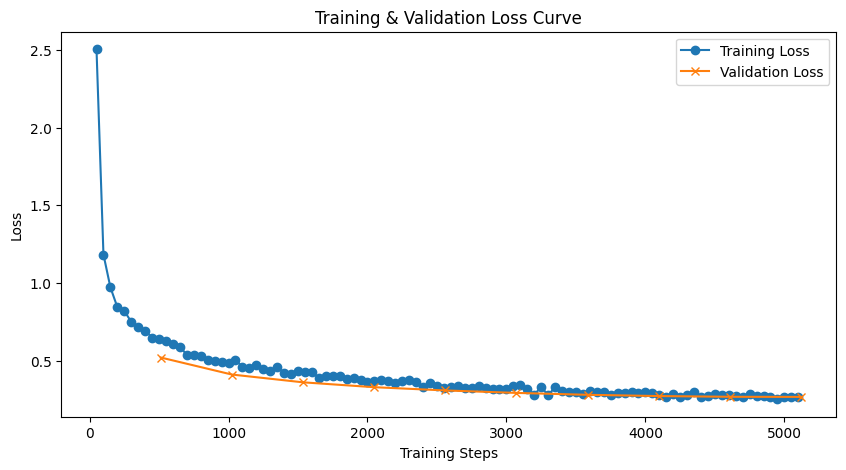

In [17]:
# ----------------------------
# 8. Plot Training Progress
# ----------------------------
loss_callback.plot_loss()

In [18]:

# ----------------------------
# 9. Save Fine-Tuned Model
# ----------------------------
model.save_pretrained("./fine_tuned_amr_t5_all_lang")
tokenizer.save_pretrained("./fine_tuned_amr_t5_all_lang")

('./fine_tuned_amr_t5_all_lang\\tokenizer_config.json',
 './fine_tuned_amr_t5_all_lang\\special_tokens_map.json',
 './fine_tuned_amr_t5_all_lang\\spiece.model',
 './fine_tuned_amr_t5_all_lang\\added_tokens.json')

In [62]:
# Take one line from all_data and show it in a nice and modern way so that I can add it in a paper

one_line = all_data[0]
one_line = json.loads(one_line)
print(one_line)
sentence = one_line["utt"]
amr = one_line["raw_amr"]
print(f"Sentence: {sentence}")
print(f"AMR: {amr}")

{'id': '15130', 'locale': 'en-US', 'partition': 'train', 'scenario': 'qa', 'intent': 'qa_factoid', 'utt': 'what road is longest', 'annot_utt': 'what road is longest', 'worker_id': '12', 'raw_amr': '(h2 / have-degree-91\n      :ARG1 (r / road\n            :mod (a / amr-unknown))\n      :ARG2 (l / long-03\n            :ARG1 r)\n      :ARG3 (m / most))'}
Sentence: what road is longest
AMR: (h2 / have-degree-91
      :ARG1 (r / road
            :mod (a / amr-unknown))
      :ARG2 (l / long-03
            :ARG1 r)
      :ARG3 (m / most))


# Calculate Smatch Score for this

In [19]:
import json
import torch
import smatch
import re
from collections import defaultdict
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import Dataset


In [20]:
# -----------------------------------
# ⿡ Load Fine-Tuned T5 Model & Tokenizer
# -----------------------------------
model_path = "./fine_tuned_amr_t5_all_lang"
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [21]:
test_dataset_for_smatch = datasets["test"]  # This already contains our test split

In [30]:
# -----------------------------------
# ⿢ Load Test Data
# -----------------------------------
file_path = "data/massive_amr_all.jsonl"

def load_amr_data(file_path):
    """Loads JSONL AMR dataset and removes missing entries."""
    with open(file_path, "r", encoding="utf-8") as file:
        data = [json.loads(line) for line in file]
    return [entry for entry in data if entry.get("raw_amr") and entry.get("utt")]

In [31]:
# Load test data
data = load_amr_data(file_path)
sentences = [entry["utt"] for entry in data]
gold_amrs = [entry["raw_amr"] for entry in data]


In [32]:
# Convert to Hugging Face Dataset format
test_dataset = Dataset.from_dict({"sentence": sentences, "amr": gold_amrs})


In [22]:
# -----------------------------------
# ⿣ Improved AMR Cleaning Function (Fix Duplicate Names)
# -----------------------------------
def fix_duplicate_nodes(amr_text):
    """Renames duplicate variables dynamically."""
    if not amr_text.strip():
        return "INVALID_AMR"

    used_vars = defaultdict(int)  # Tracks occurrences of each variable
    renamed_vars = {}

    def rename_variable(match):
        var_name = match.group(1)
        if var_name in used_vars:
            new_var_name = f"{var_name}_{used_vars[var_name]}"
            used_vars[var_name] += 1
            renamed_vars[var_name] = new_var_name
            return f"({new_var_name} /"
        else:
            used_vars[var_name] = 1
            return f"({var_name} /"

    # Ensure variables like (t2 / thing) are renamed uniquely
    amr_text = re.sub(r"\((\w+)\s+\/", rename_variable, amr_text)

    # Replace occurrences of renamed variables in AMR text
    for old_var, new_var in renamed_vars.items():
        amr_text = amr_text.replace(f" {old_var} ", f" {new_var} ")

    return amr_text


In [23]:
# -----------------------------------
# ⿤ Generate AMR Predictions (Fixed)
# -----------------------------------
def generate_amr_predictions(model, tokenizer, test_dataset, max_samples=100):
    """Generates AMR graphs from input sentences using the fine-tuned model."""
    predictions = []

    for i, example in enumerate(test_dataset):
        if i >= max_samples:  # Limit number of samples for efficiency
            break

        input_text = "parse: " + example["sentence"]
        input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

        with torch.no_grad():
            output_ids = model.generate(input_ids, max_length=512)
        
        predicted_amr = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        predicted_amr = fix_duplicate_nodes(predicted_amr)  # ✅ Ensure AMR is valid

        gold_amr = fix_duplicate_nodes(example["amr"])  # ✅ Fix duplicates in gold AMRs too

        predictions.append((gold_amr, predicted_amr))

    return predictions


In [25]:
# Generate predictions
predictions = generate_amr_predictions(model, tokenizer, test_dataset_for_smatch)


In [26]:
# -----------------------------------
# Compute Smatch Score (with Fixes)
# -----------------------------------
def is_valid_amr(amr):
    """Checks if AMR is valid by ensuring it has at least one '/' symbol."""
    return amr.count('/') > 0


In [27]:
def compute_smatch(gold_amrs, predicted_amrs):
    """Computes the Smatch score while handling errors."""
    total_precision, total_recall, total_f1 = 0, 0, 0
    valid_samples = 0

    for i, (gold, pred) in enumerate(zip(gold_amrs, predicted_amrs)):
        try:
            # ✅ Ensure AMRs are valid
            if not is_valid_amr(pred) or not is_valid_amr(gold):
                print(f"⚠ Skipping sample {i} due to invalid AMR")
                continue

            precision, recall, f_score = smatch.get_amr_match(str(gold), str(pred))
            total_precision += precision
            total_recall += recall
            total_f1 += f_score
            valid_samples += 1
        except Exception as e:
            print(f"⚠ Error in Smatch calculation for sample {i}: {e}")
            print(f"Gold AMR: {gold}")
            print(f"Predicted AMR: {pred}")
            print("-" * 50)

    if valid_samples == 0:
        return 0, 0, 0  # Avoid division by zero

    return total_precision / valid_samples, total_recall / valid_samples, total_f1 / valid_samples


In [28]:
# Extract predicted AMRs for Smatch evaluation
gold_amrs = [gold for gold, _ in predictions if gold is not None]
predicted_amrs = [pred for _, pred in predictions if pred is not None]


In [29]:
# Compute Smatch Score
precision, recall, f1 = compute_smatch(gold_amrs, predicted_amrs)

⚠ Error in Smatch calculation for sample 41: 'NoneType' object has no attribute 'rename_node'
Gold AMR: (d / describe-01 :mode imperative
      :ARG0 (y / you)
      :ARG1 (l / love-01
            :manner (r / romance-01)))
Predicted AMR: (d / describe-01 :mode imperative :ARG0 (y / you) :ARG1 (r / rord (w / word)))
--------------------------------------------------
⚠ Error in Smatch calculation for sample 69: 'NoneType' object has no attribute 'rename_node'
Gold AMR: (h2 / have-quant-91
      :ARG1 (t / thing
            :ARG1-of (s2 / sing-01)
            :ARG1-of (w / write-01
                  :ARG0 (p / person :name (n / name :op1 "michael" :op2 "jackson"))))
      :ARG2 (a / amr-unknown))
Predicted AMR: (h / have-quant-91 :ARG1 (p / person :ARG0-of (h2 / have-rel-role-91 :ARG1 (p2 / person :name (n / name :op1 "michael" :op2 "jackson")) :ARG2 (p2_1 / person :name (n2 / name :op1 "michael" :op2 "jackson"))))))
--------------------------------------------------
⚠ Error in Smatch ca

Error: Node name not found r
Unmatched parenthesis at position 208 in processing (h / have-quant-91 :ARG1 (p / person :ARG0-of (h2 / have-rel-role-91 :ARG1 (p2 / person :name (n / name :op1 "michael" :op2 "jackson")) :ARG2 (p2_1 / person :name (n2 / name :op1 "michael" :op2 "jackson"))))))
Error in parsing amr 2: (n / notify-01 :mode imperative :ARG0 (y / you) :ARG1 (t / thing :ARG2-of (p / price-01 :ARG1 (s / stock :mod (c / company :name (n2 / name :op1 "iphone")))))) :ARG2 (i / i))
Please check if the AMR is ill-formatted. Ignoring remaining AMRs
Error message: list index out of range


In [30]:
# -----------------------------------
# ⿦ Display Results
# -----------------------------------
print(f"🔥 Smatch Score - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


🔥 Smatch Score - Precision: 6.2887, Recall: 12.8660, F1: 12.0309


In [42]:
predictions[:10]

[('(h2 / have-degree-91\n      :ARG1 (r / road\n            :mod (a / amr-unknown))\n      :ARG2 (l / long-03\n            :ARG1 r)\n      :ARG3 (m / most))',
  '(h2 / have-degree-91 :ARG1 (r / route :mod (a / amr-unknown)) :ARG2 (l / long-03 :ARG1 r) :ARG3 (m / most))'),
 ('(g / give-01 :mode imperative\n      :ARG0 (y / you)\n      :ARG1 (t / thing\n            :ARG2-of (p / price-01\n                  :ARG1 (s / stock\n                        :mod (c / company :name (n / name :op1 "apple")))\n                  :time (o / open-02)))\n      :ARG2 (i / i))',
  '(p / price-01 :ARG1 (s / stock :mod (c / company :name (n / name :op1 "apple"))) :ARG2 (a / amr-unknown) :time (c2 / current))'),
 ('(h / have-quant-91\n      :ARG1 (c / currency :name (n / name :op1 "euros"))\n      :ARG2 (a / amr-unknown)\n      :ARG4 (c2 / currency :quant 1 :name (n2 / name :op1 "dollar")))',
  '(h / have-quant-91 :ARG1 (c / currency :name (n / name :op1 "euros")) :ARG2 (a / amr-unknown) :ARG4 (c2 / currency 

In [8]:
import pandas as pd

In [44]:
# id | propozitie | limba | amr | amr_predicted_all | amr_predicted_welsh+irish | amr_predicted_welsh | amr_predicted_irish | stog

# create a df with these columns, a blank one

df_results = pd.DataFrame(columns=['id', 'propozitie', 'limba', 'amr', 'amr_predicted_all', 'amr_predicted_welsh+irish', 'amr_predicted_welsh', 'amr_predicted_irish', 'stog'])

In [45]:
df_results

,id,propozitie,limba,amr,amr_predicted_all,amr_predicted_welsh+irish,amr_predicted_welsh,amr_predicted_irish,stog


In [46]:
file_path_welsh = "data/massive_amr_welsh.jsonl"
file_path_eng = "data/massive_amr.jsonl"
file_path_irish = "data/massive_amr_irish.jsonl"

def read_jsonl(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return [json.loads(line) for line in file]

welsh_data = read_jsonl(file_path_welsh)
eng_data = read_jsonl(file_path_eng)
irish_data = read_jsonl(file_path_irish)

In [49]:
# Function to add data to the dataframe
def add_data_to_df(data, language, df):
    new_rows = []
    for entry in data:
        new_rows.append({
            'id': len(df) + len(new_rows) + 1,  # Ensure continuous ID numbering
            'propozitie': entry['utt'],
            'limba': language,
            'amr': entry['raw_amr']
        })
    
    return pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

# Add data from each dataset to the dataframe
df_results = add_data_to_df(welsh_data, 'welsh', df_results)
df_results = add_data_to_df(eng_data, 'english', df_results)
df_results = add_data_to_df(irish_data, 'irish', df_results)

# Display the dataframe
df_results

,id,propozitie,limba,amr,amr_predicted_all,amr_predicted_welsh+irish,amr_predicted_welsh,amr_predicted_irish,stog
0,1,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,NaN,NaN,NaN,NaN,NaN
1,2,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,NaN,NaN,NaN,NaN,NaN
2,3,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,NaN,NaN,NaN,NaN,NaN
3,4,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,NaN,NaN,NaN,NaN,NaN
4,5,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5050,5051,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,NaN,NaN,NaN,NaN,NaN
5051,5052,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,NaN,NaN,NaN,NaN,NaN
5052,5053,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,NaN,NaN,NaN,NaN,NaN
5053,5054,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,NaN,NaN,NaN,NaN,NaN


In [9]:
import amrlib

In [67]:
stog = amrlib.load_stog_model()
graphs = stog.parse_sents(['This is a test of the system.', 'This is a second sentence.'])

for graph in graphs:
    print(graph)

# ::snt This is a test of the system.
(t / test-01
      :ARG1 (s / system)
      :domain (t2 / this))
# ::snt This is a second sentence.
(s / sentence
      :ord (o / ordinal-entity
            :value 2)
      :domain (t / this))


In [10]:
from tqdm import tqdm
from IPython.display import display, HTML, clear_output

In [69]:
# Dictionary to store results for odd ID rows
stog_results_dict = {}
failed_sentences = []

In [70]:
print("\nApplying STOG to sentences where ID is odd...\n")

# Filter only rows where 'id' is odd
df_odd = df_results[df_results['id'] % 2 == 1]

# Initialize scrollable div
output_html = "<div style='height: 300px; overflow-y: auto; border:1px solid #ccc; padding:10px;'>"

for i, (index, row) in enumerate(tqdm(df_odd.iterrows(), total=len(df_odd), desc="Processing Sentences", unit="sentence")):
    sentence = row['propozitie']
    
    try:
        parsed_graph = stog.parse_sents([sentence])[0]
        stog_results_dict[index] = parsed_graph  # Store result in dictionary
        output_html += f"<p><b>[{i+1}/{len(df_odd)}] Processed (ID {row['id']}):</b> {sentence[:50]} ✅</p>"
    except Exception as e:
        stog_results_dict[index] = None  # Ensure failed sentences are tracked
        failed_sentences.append((sentence, str(e)))
        output_html += f"<p style='color:red;'><b>[{i+1}/{len(df_odd)}] Failed (ID {row['id']}):</b> {sentence[:50]} ❌ Error: {e}</p>"
    
    # Clear the output and display updated progress
    clear_output(wait=True)
    display(HTML(output_html + "</div>"))

# ✅ Fix: Assign values using `.loc[]` and `stog_results_dict.keys()`
for idx, result in stog_results_dict.items():
    df_results.loc[idx, 'stog'] = result  # Assign only to correct rows

# Display errors if any
if failed_sentences:
    print("\n⚠️ Some sentences failed to process:\n")
    for sent, err in failed_sentences[:10]:  # Display only first 10 errors
        print(f"- Sentence: {sent}\n  Error: {err}\n")

print("\n✅ Processing complete! STOG has been applied to sentences with odd IDs.\n")

Processing Sentences: 100%|██████████| 2528/2528 [32:13<00:00,  1.31sentence/s]



✅ Processing complete! STOG has been applied to sentences with odd IDs.



In [71]:
df_results

,id,propozitie,limba,amr,amr_predicted_all,amr_predicted_welsh+irish,amr_predicted_welsh,amr_predicted_irish,stog
0,1,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,NaN,NaN,NaN,NaN,# ::snt beth yw rhai diweddariadau ar gyfer y ...
1,2,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,NaN,NaN,NaN,NaN,NaN
2,3,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,NaN,NaN,NaN,NaN,# ::snt Rydych yn chwilio i fyny rhwng cyfnewi...
3,4,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,NaN,NaN,NaN,NaN,NaN
4,5,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,NaN,NaN,NaN,NaN,# ::snt beth yw'r doler yr doler\n(p / person\...
...,...,...,...,...,...,...,...,...,...
5050,5051,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,NaN,NaN,NaN,NaN,# ::snt atá an bhean chéile na obama\n(s / say...
5051,5052,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,NaN,NaN,NaN,NaN,NaN
5052,5053,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,NaN,NaN,NaN,NaN,# ::snt cad é an ráta malairte do u. s. d. go ...
5053,5054,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,NaN,NaN,NaN,NaN,NaN


In [76]:
# Save the df_results to a csv file please
df_results.to_csv('data/df_results_updated_stog.csv', index=False)

In [3]:
# Load models and tokenizers
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
model_all_languages = T5ForConditionalGeneration.from_pretrained("./fine_tuned_amr_t5_all_lang").to(device)
tokenizer_all_languages = T5Tokenizer.from_pretrained("./fine_tuned_amr_t5_all_lang")

In [5]:
# Function to generate AMR
def generate_amr(sentence, model, tokenizer):
    """Generates AMR graph from input sentence using a given model."""
    input_text = "parse: " + sentence
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = model.generate(input_ids, max_length=512)

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [11]:
df_results = pd.read_csv('data/df_results_updated_stog.csv')

In [12]:
df_results

,id,propozitie,limba,amr,amr_predicted_all,amr_predicted_welsh+irish,amr_predicted_welsh,amr_predicted_irish,stog
0,1,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,NaN,NaN,NaN,NaN,# ::snt beth yw rhai diweddariadau ar gyfer y ...
1,2,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,NaN,NaN,NaN,NaN,NaN
2,3,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,NaN,NaN,NaN,NaN,# ::snt Rydych yn chwilio i fyny rhwng cyfnewi...
3,4,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,NaN,NaN,NaN,NaN,NaN
4,5,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,NaN,NaN,NaN,NaN,# ::snt beth yw'r doler yr doler\n(p / person\...
...,...,...,...,...,...,...,...,...,...
5050,5051,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,NaN,NaN,NaN,NaN,# ::snt atá an bhean chéile na obama\n(s / say...
5051,5052,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,NaN,NaN,NaN,NaN,NaN
5052,5053,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,NaN,NaN,NaN,NaN,# ::snt cad é an ráta malairte do u. s. d. go ...
5053,5054,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,NaN,NaN,NaN,NaN,NaN


In [13]:
# Get total sentence count
total_sentences = len(df_results)

In [14]:
print("\nApplying AMR prediction to all sentences...\n")

# Initialize scrollable progress output
output_html = "<div style='height: 300px; overflow-y: auto; border:1px solid #ccc; padding:10px;'>"


Applying AMR prediction to all sentences...



In [15]:
# Iterate through dataset and make predictions in ONE loop
for i, (index, row) in enumerate(tqdm(df_results.iterrows(), total=len(df_results), desc="Processing Sentences", unit="sentence")):
    sentence = row["propozitie"]
    
    try:
        # 🔥 Predict AMR for all languages
        amr_output = generate_amr(sentence, model_all_languages, tokenizer_all_languages)
        df_results.at[index, "amr_predicted_all"] = amr_output
        
        # ✅ Update progress log
        output_html += f"<p><b>[{i+1}/{total_sentences}] Processed (ID {row['id']}):</b> {sentence[:50]} ✅</p>"
    
    except Exception as e:
        df_results.at[index, "amr_predicted_all"] = None  # Handle failure case
        output_html += f"<p style='color:red;'><b>[{i+1}/{total_sentences}] Failed (ID {row['id']}):</b> {sentence[:50]} ❌ Error: {e}</p>"

    # Clear previous output and update progress
    clear_output(wait=True)
    display(HTML(output_html + "</div>"))
    
print("\n✅ AMR processing complete for all sentences!\n")
# Save the df_results to a csv file please
df_results.to_csv('data/df_results_updated_stog_amr_all.csv', index=False)

Processing Sentences: 100%|██████████| 5055/5055 [1:11:37<00:00,  1.18sentence/s]


✅ AMR processing complete for all sentences!



In [16]:
model_welsh = T5ForConditionalGeneration.from_pretrained("./fine_tuned_amr_t5").to(device)
tokenizer_welsh = T5Tokenizer.from_pretrained("./fine_tuned_amr_t5")

In [17]:
# Get total sentence count
total_sentences = len(df_results)
print("\nApplying AMR prediction to all sentences...\n")


Applying AMR prediction to all sentences...



In [19]:
# Initialize scrollable progress output
output_html = "<div style='height: 300px; overflow-y: auto; border:1px solid #ccc; padding:10px;'>"
# Iterate through dataset and make predictions in ONE loop
for i, (index, row) in enumerate(tqdm(df_results.iterrows(), total=len(df_results), desc="Processing Sentences", unit="sentence")):
    sentence = row["propozitie"]
    if row["limba"] != "welsh":
        continue # Skip non-Welsh sentences
    try:
        # 🔥 Predict AMR for Welsh
        amr_output = generate_amr(sentence, model_welsh, tokenizer_welsh)
        df_results.at[index, "amr_predicted_welsh"] = amr_output
        
        # ✅ Update progress log
        output_html += f"<p><b>[{i+1}/{total_sentences}] Processed (ID {row['id']}):</b> {sentence[:50]} ✅</p>"
    
    except Exception as e:
        df_results.at[index, "amr_predicted_welsh"] = None  # Handle failure case
        output_html += f"<p style='color:red;'><b>[{i+1}/{total_sentences}] Failed (ID {row['id']}):</b> {sentence[:50]} ❌ Error: {e}</p>"

    # Clear previous output and update progress
    clear_output(wait=True)
    display(HTML(output_html + "</div>"))
    
print("\n✅ AMR processing complete for all sentences!\n")

Processing Sentences: 100%|██████████| 5055/5055 [31:28<00:00,  2.68sentence/s]  


✅ AMR processing complete for all sentences!



In [20]:
# Check how much rows have a valid "amr_predicted_welsh" value
valid_welsh_amr_count = df_results["amr_predicted_welsh"].count()
print(f"✅ Valid Welsh AMR predictions: {valid_welsh_amr_count}/{total_sentences}")

✅ Valid Welsh AMR predictions: 2661/5055


In [21]:
df_results

,id,propozitie,limba,amr,amr_predicted_all,amr_predicted_welsh+irish,amr_predicted_welsh,amr_predicted_irish,stog
0,1,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,NaN,(t / tell-01 :mode imperative :ARG0 (y / you) ...,NaN,# ::snt beth yw rhai diweddariadau ar gyfer y ...
1,2,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,NaN
2,3,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,"(c / country :name (n / name :op1 ""mexico"") :m...",NaN,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,NaN,# ::snt Rydych yn chwilio i fyny rhwng cyfnewi...
3,4,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,(d / describe-01 :mode imperative :polite + :A...,NaN,(d / describe-01 :mode imperative :polite + :A...,NaN,NaN
4,5,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,(h / have-quant-91 :ARG1 (c / currency :name (...,NaN,(h / have-degree-91 :ARG1 (c / currency :name ...,NaN,# ::snt beth yw'r doler yr doler\n(p / person\...
...,...,...,...,...,...,...,...,...,...
5050,5051,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,(b / bear-02 :ARG1 (p / person :name (n / name...,NaN,NaN,NaN,# ::snt atá an bhean chéile na obama\n(s / say...
5051,5052,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,(m / mean-01 :ARG1 (j / joke-01) :ARG2 (a / am...,NaN,NaN,NaN,NaN
5052,5053,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,NaN,NaN,NaN,# ::snt cad é an ráta malairte do u. s. d. go ...
5053,5054,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,NaN,NaN,NaN,NaN


In [22]:
# Safely copy df_results to a new dataframe
df_results_copy = df_results.copy()

In [23]:
# Put Nan in the "amr_predicted_welsh" column where the language is not welsh
df_results.loc[df_results['limba'] != 'welsh', 'amr_predicted_welsh'] = None

In [24]:
# Check how much rows have a valid "amr_predicted_welsh" value
valid_welsh_amr_count = df_results["amr_predicted_welsh"].count()
print(f"✅ Valid Welsh AMR predictions: {valid_welsh_amr_count}/{total_sentences}")

✅ Valid Welsh AMR predictions: 1685/5055


In [25]:
df_results

,id,propozitie,limba,amr,amr_predicted_all,amr_predicted_welsh+irish,amr_predicted_welsh,amr_predicted_irish,stog
0,1,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,NaN,(t / tell-01 :mode imperative :ARG0 (y / you) ...,NaN,# ::snt beth yw rhai diweddariadau ar gyfer y ...
1,2,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,NaN
2,3,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,"(c / country :name (n / name :op1 ""mexico"") :m...",NaN,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,NaN,# ::snt Rydych yn chwilio i fyny rhwng cyfnewi...
3,4,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,(d / describe-01 :mode imperative :polite + :A...,NaN,(d / describe-01 :mode imperative :polite + :A...,NaN,NaN
4,5,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,(h / have-quant-91 :ARG1 (c / currency :name (...,NaN,(h / have-degree-91 :ARG1 (c / currency :name ...,NaN,# ::snt beth yw'r doler yr doler\n(p / person\...
...,...,...,...,...,...,...,...,...,...
5050,5051,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,(b / bear-02 :ARG1 (p / person :name (n / name...,NaN,None,NaN,# ::snt atá an bhean chéile na obama\n(s / say...
5051,5052,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,(m / mean-01 :ARG1 (j / joke-01) :ARG2 (a / am...,NaN,None,NaN,NaN
5052,5053,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,NaN,None,NaN,# ::snt cad é an ráta malairte do u. s. d. go ...
5053,5054,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,NaN,None,NaN,NaN


In [26]:
# Save the updated DataFrame to a CSV file
df_results.to_csv('data/df_results_updated_stog_amr_all_and_single_welsh.csv', index=False)

In [32]:
# Load the other csv file from data/df_results_updated_stog_welsh+irish_irish.csv and combine it with the current df_results
df_results1 = df_results
df_results2 = pd.read_csv('data/df_results_updated_stog_welsh+irish_irish.csv')

df_results_combined = pd.merge(df_results1, df_results2, on='id', how='outer')

# Save the combined DataFrame to a CSV file
df_results_combined.to_csv('data/df_results_combined.csv', index=False)

In [34]:
df_results_combined

,id,propozitie_x,limba_x,amr_x,amr_predicted_all_x,amr_predicted_welsh+irish_x,amr_predicted_welsh_x,amr_predicted_irish_x,stog_x,propozitie_y,limba_y,amr_y,amr_predicted_all_y,amr_predicted_welsh+irish_y,amr_predicted_welsh_y,amr_predicted_irish_y,stog_y
0,1,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,NaN,(t / tell-01 :mode imperative :ARG0 (y / you) ...,NaN,# ::snt beth yw rhai diweddariadau ar gyfer y ...,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,NaN,(d / do-02 :ARG0 (p / price-01 :ARG1 (s / stoc...,NaN,NaN,NaN
1,2,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,NaN,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,NaN,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,NaN,# ::snt animeiddiad y tu hwnt i'r diffiniadCit...
2,3,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,"(c / country :name (n / name :op1 ""mexico"") :m...",NaN,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,NaN,# ::snt Rydych yn chwilio i fyny rhwng cyfnewi...,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,NaN,(l / look-02 :ARG0 (i / i) :ARG1 (t / thing :A...,NaN,NaN,NaN
3,4,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,(d / describe-01 :mode imperative :polite + :A...,NaN,(d / describe-01 :mode imperative :polite + :A...,NaN,NaN,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,NaN,(d / describe-01 :polite + :mode imperative :p...,NaN,NaN,# ::snt Gallwch ddisgrifio i mi yr hyn sy'n ia...
4,5,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,(h / have-quant-91 :ARG1 (c / currency :name (...,NaN,(h / have-degree-91 :ARG1 (c / currency :name ...,NaN,# ::snt beth yw'r doler yr doler\n(p / person\...,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,NaN,(h / have-quant-91 :ARG1 (c / currency :name (...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5050,5051,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,(b / bear-02 :ARG1 (p / person :name (n / name...,NaN,None,NaN,# ::snt atá an bhean chéile na obama\n(s / say...,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,NaN,(b / be-located-at-91 :ARG1 (p / person :name ...,NaN,(b / be-located-at-91 :ARG1 (p / person :name ...,NaN
5051,5052,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,(m / mean-01 :ARG1 (j / joke-01) :ARG2 (a / am...,NaN,None,NaN,NaN,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,NaN,(h / have-quant-91 :ARG1 (r / joke-01 :ARG1 (p...,NaN,(m / mean-01 :ARG1 (joice :mod (t / this)) :AR...,# ::snt cad a dhéanann joke chiallaíonn\n(s / ...
5052,5053,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,NaN,None,NaN,# ::snt cad é an ráta malairte do u. s. d. go ...,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,NaN,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,NaN,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,NaN
5053,5054,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,NaN,None,NaN,NaN,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,NaN,(t / tell-01 :mode imperative :ARG0 (y / you) ...,NaN,(t / tel

In [35]:
# drop amr_predicted_welsh+irish_x, amr_predicted_irish_x, propozitie_y, limba_y, amr_y, amr_predicted_all_y, amr_predicted_welsh_y
df_results_combined = df_results_combined.drop(columns=['amr_predicted_welsh+irish_x', 'amr_predicted_irish_x', 'propozitie_y', 'limba_y', 'amr_y', 'amr_predicted_all_y', 'amr_predicted_welsh_y'])

In [36]:
df_results_combined

,id,propozitie_x,limba_x,amr_x,amr_predicted_all_x,amr_predicted_welsh_x,stog_x,amr_predicted_welsh+irish_y,amr_predicted_irish_y,stog_y
0,1,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,# ::snt beth yw rhai diweddariadau ar gyfer y ...,(d / do-02 :ARG0 (p / price-01 :ARG1 (s / stoc...,NaN,NaN
1,2,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,(d / define-01 :ARG1 (p / person :name (n / na...,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,# ::snt animeiddiad y tu hwnt i'r diffiniadCit...
2,3,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,"(c / country :name (n / name :op1 ""mexico"") :m...",(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,# ::snt Rydych yn chwilio i fyny rhwng cyfnewi...,(l / look-02 :ARG0 (i / i) :ARG1 (t / thing :A...,NaN,NaN
3,4,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,(d / describe-01 :mode imperative :polite + :A...,(d / describe-01 :mode imperative :polite + :A...,NaN,(d / describe-01 :polite + :mode imperative :p...,NaN,# ::snt Gallwch ddisgrifio i mi yr hyn sy'n ia...
4,5,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,(h / have-quant-91 :ARG1 (c / currency :name (...,(h / have-degree-91 :ARG1 (c / currency :name ...,# ::snt beth yw'r doler yr doler\n(p / person\...,(h / have-quant-91 :ARG1 (c / currency :name (...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5050,5051,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,(b / bear-02 :ARG1 (p / person :name (n / name...,None,# ::snt atá an bhean chéile na obama\n(s / say...,(b / be-located-at-91 :ARG1 (p / person :name ...,(b / be-located-at-91 :ARG1 (p / person :name ...,NaN
5051,5052,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,(m / mean-01 :ARG1 (j / joke-01) :ARG2 (a / am...,None,NaN,(h / have-quant-91 :ARG1 (r / joke-01 :ARG1 (p...,(m / mean-01 :ARG1 (joice :mod (t / this)) :AR...,# ::snt cad a dhéanann joke chiallaíonn\n(s / ...
5052,5053,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,None,# ::snt cad é an ráta malairte do u. s. d. go ...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,NaN
5053,5054,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,None,NaN,(t / tell-01 :mode imperative :ARG0 (y / you) ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,# ::snt inis dom a bhuaigh an chéad toghchán u...


In [37]:
# Merge the stog_x and stog_y columns into a single stog column, because the odd ids have the stog results in the stog_x column and the even ids have the stog results in the stog_y column
df_results_combined['stog'] = df_results_combined['stog_x'].combine_first(df_results_combined['stog_y'])

In [38]:
df_results_combined

,id,propozitie_x,limba_x,amr_x,amr_predicted_all_x,amr_predicted_welsh_x,stog_x,amr_predicted_welsh+irish_y,amr_predicted_irish_y,stog_y,stog
0,1,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,# ::snt beth yw rhai diweddariadau ar gyfer y ...,(d / do-02 :ARG0 (p / price-01 :ARG1 (s / stoc...,NaN,NaN,# ::snt beth yw rhai diweddariadau ar gyfer y ...
1,2,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,(d / define-01 :ARG1 (p / person :name (n / na...,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,# ::snt animeiddiad y tu hwnt i'r diffiniadCit...,# ::snt animeiddiad y tu hwnt i'r diffiniadCit...
2,3,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,"(c / country :name (n / name :op1 ""mexico"") :m...",(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,# ::snt Rydych yn chwilio i fyny rhwng cyfnewi...,(l / look-02 :ARG0 (i / i) :ARG1 (t / thing :A...,NaN,NaN,# ::snt Rydych yn chwilio i fyny rhwng cyfnewi...
3,4,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,(d / describe-01 :mode imperative :polite + :A...,(d / describe-01 :mode imperative :polite + :A...,NaN,(d / describe-01 :polite + :mode imperative :p...,NaN,# ::snt Gallwch ddisgrifio i mi yr hyn sy'n ia...,# ::snt Gallwch ddisgrifio i mi yr hyn sy'n ia...
4,5,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,(h / have-quant-91 :ARG1 (c / currency :name (...,(h / have-degree-91 :ARG1 (c / currency :name ...,# ::snt beth yw'r doler yr doler\n(p / person\...,(h / have-quant-91 :ARG1 (c / currency :name (...,NaN,NaN,# ::snt beth yw'r doler yr doler\n(p / person\...
...,...,...,...,...,...,...,...,...,...,...,...
5050,5051,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,(b / bear-02 :ARG1 (p / person :name (n / name...,None,# ::snt atá an bhean chéile na obama\n(s / say...,(b / be-located-at-91 :ARG1 (p / person :name ...,(b / be-located-at-91 :ARG1 (p / person :name ...,NaN,# ::snt atá an bhean chéile na obama\n(s / say...
5051,5052,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,(m / mean-01 :ARG1 (j / joke-01) :ARG2 (a / am...,None,NaN,(h / have-quant-91 :ARG1 (r / joke-01 :ARG1 (p...,(m / mean-01 :ARG1 (joice :mod (t / this)) :AR...,# ::snt cad a dhéanann joke chiallaíonn\n(s / ...,# ::snt cad a dhéanann joke chiallaíonn\n(s / ...
5052,5053,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,None,# ::snt cad é an ráta malairte do u. s. d. go ...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,NaN,# ::snt cad é an ráta malairte do u. s. d. go ...
5053,5054,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,None,NaN,(t / tell-01 :mode imperative :ARG0 (y / you) ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,# ::snt inis dom a bhuaigh an chéad toghchán u...,# ::snt inis dom a bhuaigh an chéad toghchán u...


In [39]:
# drop stog_x and stog_y columns
df_results_combined = df_results_combined.drop(columns=['stog_x', 'stog_y'])

In [40]:
df_results_combined

,id,propozitie_x,limba_x,amr_x,amr_predicted_all_x,amr_predicted_welsh_x,amr_predicted_welsh+irish_y,amr_predicted_irish_y,stog
0,1,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,(d / do-02 :ARG0 (p / price-01 :ARG1 (s / stoc...,NaN,# ::snt beth yw rhai diweddariadau ar gyfer y ...
1,2,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,(d / define-01 :ARG1 (p / person :name (n / na...,(d / define-01 :ARG1 (p / person :name (n / na...,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,# ::snt animeiddiad y tu hwnt i'r diffiniadCit...
2,3,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,"(c / country :name (n / name :op1 ""mexico"") :m...",(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,(l / look-02 :ARG0 (i / i) :ARG1 (t / thing :A...,NaN,# ::snt Rydych yn chwilio i fyny rhwng cyfnewi...
3,4,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,(d / describe-01 :mode imperative :polite + :A...,(d / describe-01 :mode imperative :polite + :A...,(d / describe-01 :polite + :mode imperative :p...,NaN,# ::snt Gallwch ddisgrifio i mi yr hyn sy'n ia...
4,5,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,(h / have-quant-91 :ARG1 (c / currency :name (...,(h / have-degree-91 :ARG1 (c / currency :name ...,(h / have-quant-91 :ARG1 (c / currency :name (...,NaN,# ::snt beth yw'r doler yr doler\n(p / person\...
...,...,...,...,...,...,...,...,...,...
5050,5051,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,(b / bear-02 :ARG1 (p / person :name (n / name...,None,(b / be-located-at-91 :ARG1 (p / person :name ...,(b / be-located-at-91 :ARG1 (p / person :name ...,# ::snt atá an bhean chéile na obama\n(s / say...
5051,5052,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,(m / mean-01 :ARG1 (j / joke-01) :ARG2 (a / am...,None,(h / have-quant-91 :ARG1 (r / joke-01 :ARG1 (p...,(m / mean-01 :ARG1 (joice :mod (t / this)) :AR...,# ::snt cad a dhéanann joke chiallaíonn\n(s / ...
5052,5053,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,None,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,# ::snt cad é an ráta malairte do u. s. d. go ...
5053,5054,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,None,(t / tell-01 :mode imperative :ARG0 (y / you) ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,# ::snt inis dom a bhuaigh an chéad toghchán u...


In [41]:
# Save the updated DataFrame to a CSV file
df_results_combined.to_csv('data/df_results_combined_final.csv', index=False)

In [63]:
# Rename propozitie_x to propozitie,
# limba_x to limba,
# amr_x to amr,
# amr_predicted_all_x to amr_predicted_all,
# amr_predicted_welsh_x to amr_predicted_welsh,
# stog to stog,
# amr_predicted_irish_y to amr_predicted_irish,
# amr_predicted_welsh+irish_y to amr_predicted_welsh+irish
df_results_combined = df_results_combined.rename(columns={
    'propozitie_x': 'propozitie',
    'limba_x': 'limba',
    'amr_x': 'amr',
    'amr_predicted_all_x': 'amr_predicted_all',
    'amr_predicted_welsh_x': 'amr_predicted_welsh',
    'amr_predicted_irish_y': 'amr_predicted_irish',
    'amr_predicted_welsh+irish_y': 'amr_predicted_welsh+irish'
})

df_results_combined

,id,propozitie,limba,amr,amr_predicted_all,amr_predicted_welsh,amr_predicted_welsh+irish,amr_predicted_irish,stog
0,1,beth yw rhai diweddariadau ar gyfer y farchnad...,welsh,(u / update-02\n :ARG2 (a / amr-unknown)\...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,(d / do-02 :ARG0 (p / price-01 :ARG1 (s / stoc...,NaN,# ::snt beth yw rhai diweddariadau ar gyfer y ...
1,2,animeiddiad y tu hwnt i'r diffiniadCity name (...,welsh,(d / define-01\n :ARG1 (v / velocity)\n ...,(d / define-01 :ARG1 (p / person :name (n / na...,(d / define-01 :ARG1 (p / person :name (n / na...,(d / define-01 :ARG1 (p / person :name (n / na...,NaN,# ::snt animeiddiad y tu hwnt i'r diffiniadCit...
2,3,Rydych yn chwilio i fyny rhwng cyfnewid rhwng ...,welsh,(l / look-up-05 :mode imperative :polite +\n ...,"(c / country :name (n / name :op1 ""mexico"") :m...",(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,(l / look-02 :ARG0 (i / i) :ARG1 (t / thing :A...,NaN,# ::snt Rydych yn chwilio i fyny rhwng cyfnewi...
3,4,Gallwch ddisgrifio i mi yr hyn sy'n iach yn ed...,welsh,(d / describe-01 :mode imperative :polite +\n ...,(d / describe-01 :mode imperative :polite + :A...,(d / describe-01 :mode imperative :polite + :A...,(d / describe-01 :polite + :mode imperative :p...,NaN,# ::snt Gallwch ddisgrifio i mi yr hyn sy'n ia...
4,5,beth yw'r doler yr doler,welsh,(h / have-quant-91\n :ARG1 (c / currency ...,(h / have-quant-91 :ARG1 (c / currency :name (...,(h / have-degree-91 :ARG1 (c / currency :name ...,(h / have-quant-91 :ARG1 (c / currency :name (...,NaN,# ::snt beth yw'r doler yr doler\n(p / person\...
...,...,...,...,...,...,...,...,...,...
5050,5051,atá an bhean chéile na obama,irish,(h2 / have-rel-role-91\n :ARG0 (a / amr-u...,(b / bear-02 :ARG1 (p / person :name (n / name...,None,(b / be-located-at-91 :ARG1 (p / person :name ...,(b / be-located-at-91 :ARG1 (p / person :name ...,# ::snt atá an bhean chéile na obama\n(s / say...
5051,5052,cad a dhéanann joke chiallaíonn,irish,(m / mean-01\n :ARG1 (j / joke-01)\n ...,(m / mean-01 :ARG1 (j / joke-01) :ARG2 (a / am...,None,(h / have-quant-91 :ARG1 (r / joke-01 :ARG1 (p...,(m / mean-01 :ARG1 (joice :mod (t / this)) :AR...,# ::snt cad a dhéanann joke chiallaíonn\n(s / ...
5052,5053,cad é an ráta malairte do u. s. d. go nzd,irish,(r / rate-01\n :ARG1 (e / exchange-01\n ...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,None,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,(r / rate-01 :ARG1 (e / exchange-01 :ARG1 (c /...,# ::snt cad é an ráta malairte do u. s. d. go ...
5053,5054,inis dom a bhuaigh an chéad toghchán uachtarán...,irish,(t / tell-01 :mode imperative\n :ARG0 (y ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,None,(t / tell-01 :mode imperative :ARG0 (y / you) ...,(t / tell-01 :mode imperative :ARG0 (y / you) ...,# ::snt inis dom a bhuaigh an chéad toghchán u...


In [64]:
df_results_combined.to_csv('data/df_results_combined_final.csv', index=False)

In [65]:
df = pd.read_csv('data/df_results_combined_final.csv')

In [66]:
# Display basic info and first rows
print("Dataset Overview:")
print(df.info())
print(df.head())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         5055 non-null   int64 
 1   propozitie                 5055 non-null   object
 2   limba                      5055 non-null   object
 3   amr                        5055 non-null   object
 4   amr_predicted_all          5055 non-null   object
 5   amr_predicted_welsh        1685 non-null   object
 6   amr_predicted_welsh+irish  3370 non-null   object
 7   amr_predicted_irish        1685 non-null   object
 8   stog                       5055 non-null   object
dtypes: int64(1), object(8)
memory usage: 355.6+ KB
None
   id                                         propozitie  limba  \
0   1  beth yw rhai diweddariadau ar gyfer y farchnad...  welsh   
1   2  animeiddiad y tu hwnt i'r diffiniadCity name (...  welsh   
2   3  Rydych

In [67]:
# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
id                              0
propozitie                      0
limba                           0
amr                             0
amr_predicted_all               0
amr_predicted_welsh          3370
amr_predicted_welsh+irish    1685
amr_predicted_irish          3370
stog                            0
dtype: int64


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import jaccard_score
from difflib import SequenceMatcher
from tqdm import tqdm

In [72]:
# Function to compute similarity between AMRs using SequenceMatcher
def compute_similarity(amr1, amr2):
    if pd.isna(amr1) or pd.isna(amr2):
        return None
    return SequenceMatcher(None, amr1, amr2).ratio()

In [73]:
# Compute similarity between original AMR and each predicted AMR
similarity_columns = ['amr_predicted_all', 'amr_predicted_welsh', 'amr_predicted_welsh+irish', 'amr_predicted_irish', 'stog']
for col in tqdm(similarity_columns, desc="Computing Similarities"):
    df[f'similarity_{col}'] = df.apply(lambda row: compute_similarity(row['amr'], row[col]), axis=1)

Computing Similarities: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


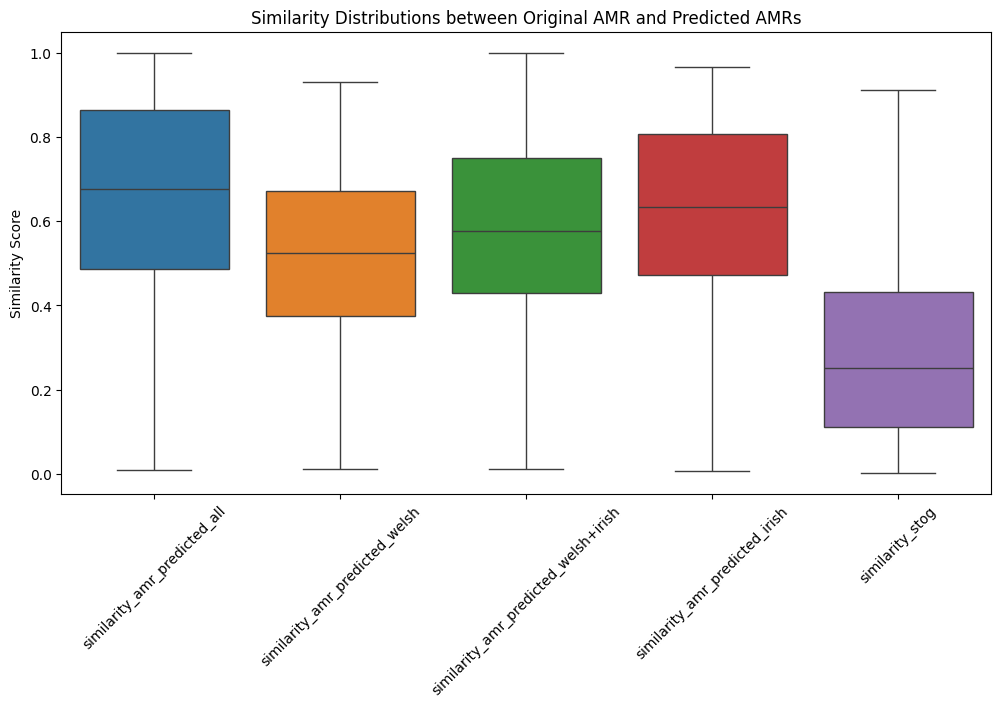

In [74]:
# Visualize similarity distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[[f'similarity_{col}' for col in similarity_columns]])
plt.title("Similarity Distributions between Original AMR and Predicted AMRs")
plt.xticks(rotation=45)
plt.ylabel("Similarity Score")
plt.show()


In [75]:
# Mean similarity scores per model
mean_similarities = df[[f'similarity_{col}' for col in similarity_columns]].mean()
print("\nMean Similarity Scores:")
print(mean_similarities)


Mean Similarity Scores:
similarity_amr_predicted_all            0.655880
similarity_amr_predicted_welsh          0.524328
similarity_amr_predicted_welsh+irish    0.580876
similarity_amr_predicted_irish          0.621860
similarity_stog                         0.297012
dtype: float64


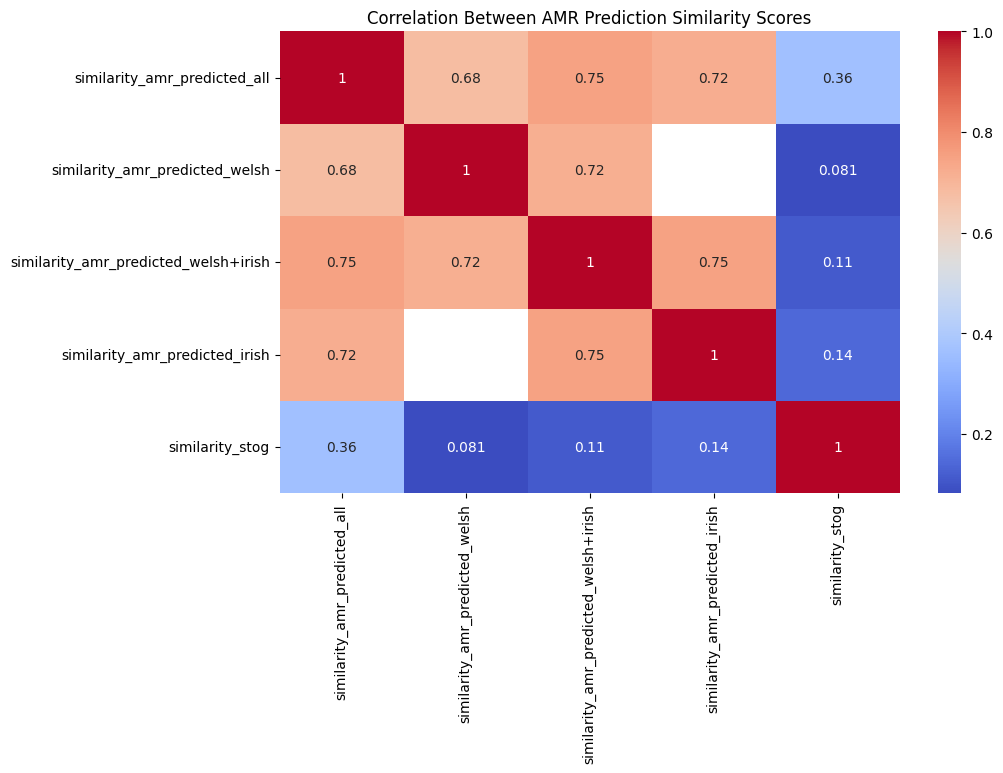

In [76]:
# Correlation heatmap to analyze relationships between different AMR versions
plt.figure(figsize=(10, 6))
sns.heatmap(df[[f'similarity_{col}' for col in similarity_columns]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between AMR Prediction Similarity Scores")
plt.show()

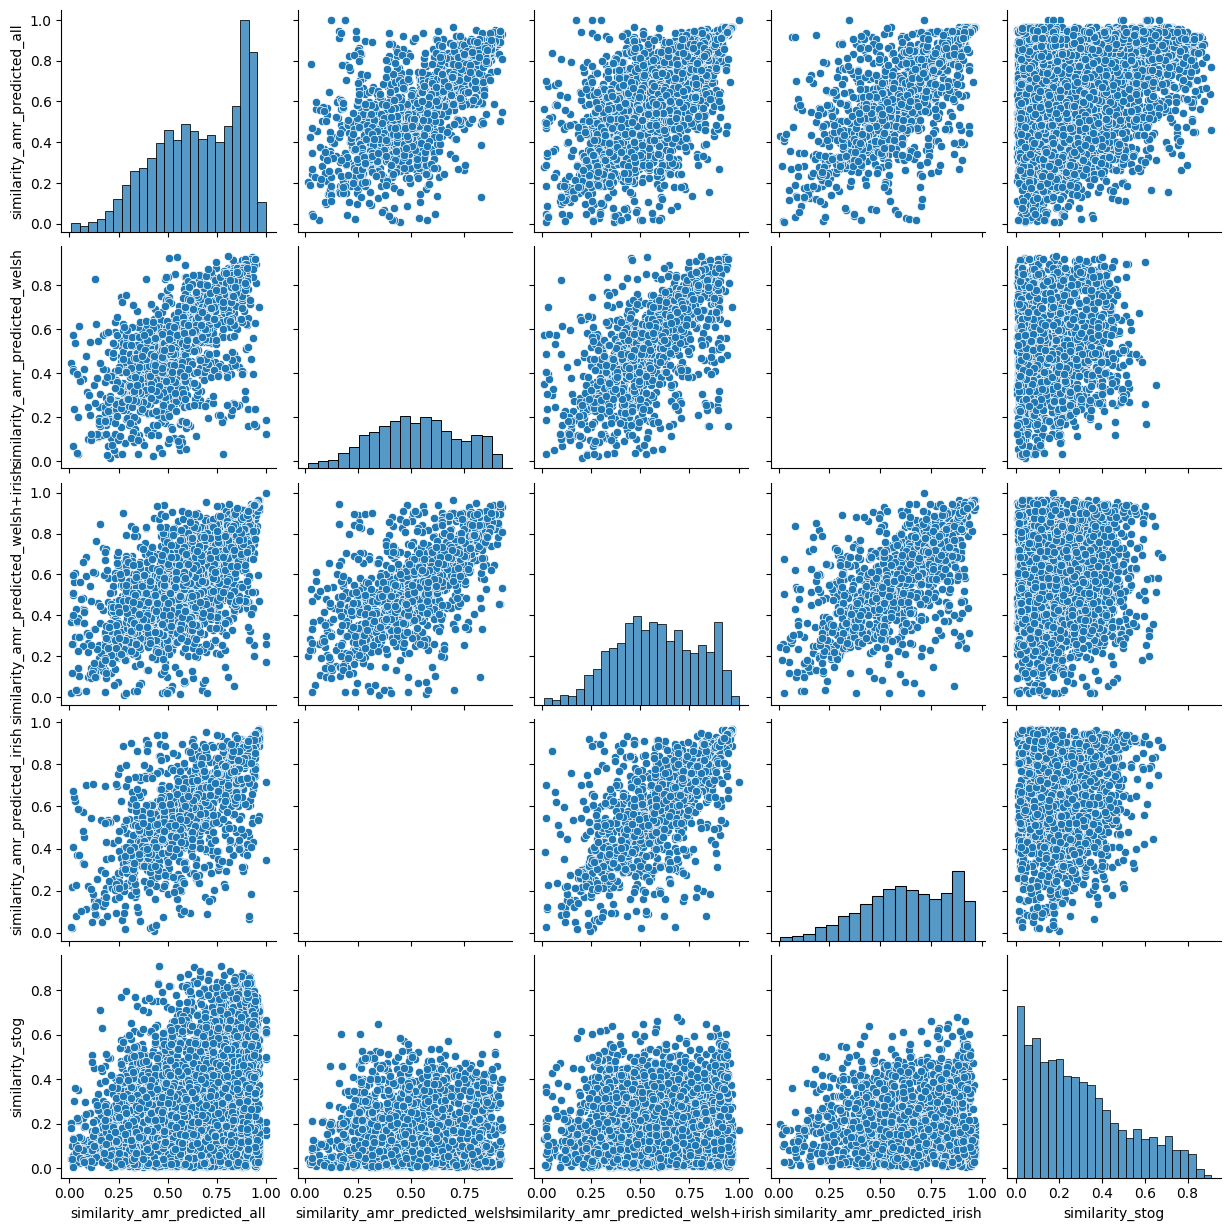

In [77]:
# Scatter plots to analyze relationships between models
sns.pairplot(df[[f'similarity_{col}' for col in similarity_columns]])
plt.show()